In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable


In [2]:
data_X = torch.randn(256,100) 
print('data_X.shape=', data_X.shape)
solution_true = torch.randn(100,100) # modify output dimension to 1 for overparametrized case
print('solution_true.shape=', solution_true.shape)
noise = 1
data_y = data_X @ solution_true + noise * torch.randn(256,100) # modify output dimension according to X
print('data_y.shape=', data_y.shape)

data_X.shape= torch.Size([256, 100])
solution_true.shape= torch.Size([100, 100])
data_y.shape= torch.Size([256, 100])


In [2]:

# 2-layer net
class SmallNet(nn.Module):
    def __init__(self, inputdim, hiddendim, outputdim):
        super().__init__()
        self.linear1 = nn.Linear(inputdim, hiddendim)
        self.linear2 = nn.Linear(hiddendim, outputdim)
    def forward(self, input):
        linear1_out = self.linear1(input)
        # linear1_activation = F.relu(linear1_out)
        linear2_out = self.linear2(linear1_out)
        return linear2_out       

In [3]:
# train 2-layer net
def train_fullnet(data_X, data_y, model, lr, num_epoch=20, batch_size=32):
    loss_hist = []
    for e in range(num_epoch):
        print(f'In epoch {e}:')
        idx = torch.randperm(data_X.size(0))
        running_loss = 0
        num_iters = data_X.size(0)//batch_size
        for i in range(num_iters):
            X = data_X[idx[i*batch_size:(i+1)*batch_size]]
            y = data_y[idx[i*batch_size:(i+1)*batch_size]]
            loss = torch.pow(torch.norm(y - model(X), 'fro'),2)/batch_size
            # optimizer.zero_grad()
            for p in model.parameters():
                if p.grad is not None:
                    p.grad.detach()
                    p.grad.zero_()
            loss.backward()
            for p in model.parameters():
                if p.grad is not None:
                    p.data.add_(-lr, p.grad.data)
            running_loss += loss.item()
            loss_hist.append(loss.item())
        print(f'loss:{running_loss/num_iters}')
    return loss_hist.copy()

In epoch 0:
loss:87.43021976947784
In epoch 1:
loss:28.669333398342133
In epoch 0:
loss:64.33169054985046
In epoch 1:
loss:31.15455996990204
In epoch 0:
loss:60.01077741384506
In epoch 1:
loss:32.20836699008942
In epoch 0:
loss:56.44521999359131
In epoch 1:
loss:43.19636392593384


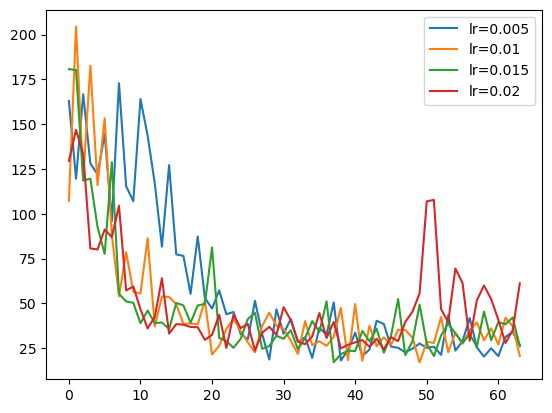

In [68]:

model = SmallNet(100,100,100)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# train_fullnet(data_X, data_y, model, 0.01, 20, 32)
loss_hist = {}
for lr in [0.005,0.01,0.015,0.02]:
    model = SmallNet(100,100,1)
    loss_hist[lr] = train_fullnet(data_X, data_y, model, lr, 2, 32)
    plt.plot(torch.arange(len(loss_hist[lr])//1), loss_hist[lr][:len(loss_hist[lr])//1], label=f'lr={lr}')
plt.legend()
plt.show()

In [51]:
net = SmallNet(100,50,1)
dict = net.state_dict()
print(dict.keys())
for name in dict.keys():
    print(dict[name].shape)

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])
torch.Size([50, 100])
torch.Size([50])
torch.Size([1, 50])
torch.Size([1])


In [4]:
def downsampling(big_net, small_net):
    big_dict = big_net.state_dict()
    small_dict = small_net.state_dict()
    for name in ['linear1.weight', 'linear1.bias']:
        small_dict[name] = big_dict[name][::2].clone()
    for name in ['linear2.weight']:
        small_dict[name] = big_dict[name][:,::2].clone()
    for name in ['linear2.bias']:
        small_dict[name] = big_dict[name].clone()
    small_net.load_state_dict(small_dict)
    return small_net

def upsampling(big_net, small_net, small_dict_old):
    big_dict = big_net.state_dict()
    small_dict = small_net.state_dict()
    bigdict_update = {}
    for name in ['linear1.weight', 'linear1.bias']:
        smallnet_update = small_dict[name]-small_dict_old[name]
        bignet_update = torch.zeros_like(big_dict[name])
        bignet_update[::2] = smallnet_update
        for idx in range(1,big_dict[name].shape[0],2):
            bignet_update[idx] = (bignet_update[idx-1] + bignet_update[idx+1]) / 2
        bigdict_update[name] = bignet_update
    for name in ['linear2.weight']:
        smallnet_update = small_dict[name]-small_dict_old[name]
        bignet_update = torch.zeros_like(big_dict[name])
        bignet_update[:,::2] = smallnet_update
        for idx in range(1,big_dict[name].shape[1],2):
            bignet_update[:,idx] = (bignet_update[:,idx-1] + bignet_update[:,idx+1]) / 2
        bigdict_update[name] = bignet_update
    for name in ['linear2.bias']:
        bigdict_update[name] = small_dict[name]-small_dict_old[name]
    for name in ['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias']:
        big_dict[name].add_(bigdict_update[name])
    big_net.load_state_dict(big_dict)
    return big_net
        
def mixed_training(data_X, data_y, model_big, model_small, lr_big, lr_small, num_epoch_big=2, num_epoch_small=10, batch_size=32):
    loss_hist = []
    loss_mixed = []
    for e in range(num_epoch_big):
        print(f'In epoch {e}:')
        downsampling(model_big, model_small)
        smalldict_backup = {}
        for name in model_small.state_dict().keys():
            smalldict_backup[name] = model_small.state_dict()[name].clone()
        for ee in range(num_epoch_small):
            idx = torch.randperm(data_X.size(0))
            num_iters = data_X.size(0)//batch_size
            for i in range(num_iters):
                X = data_X[idx[i*batch_size:(i+1)*batch_size]]
                y = data_y[idx[i*batch_size:(i+1)*batch_size]]
                loss = torch.pow(torch.norm(y-model_small(X), 'fro'),2)/batch_size
                for p in model_small.parameters():
                    if p.grad is not None:
                        p.grad.detach()
                        p.grad.zero_()
                loss.backward()
                for p in model_small.parameters():
                    if p.grad is not None:
                        p.data.add_(-lr_small, p.grad.data)
                loss_mixed.append(loss.item())
        upsampling(model_big, model_small, smalldict_backup)
        idx = torch.randperm(data_X.size(0))
        running_loss = 0
        num_iters = data_X.size(0)//batch_size
        for i in range(num_iters):
            X = data_X[idx[i*batch_size:(i+1)*batch_size]]
            y = data_y[idx[i*batch_size:(i+1)*batch_size]]
            loss = torch.pow(torch.norm(y-model_big(X), 'fro'),2)/batch_size
            for p in model_big.parameters():
                if p.grad is not None:
                    p.grad.detach()
                    p.grad.zero_()
            loss.backward()
            for p in model_big.parameters():
                if p.grad is not None:
                    p.data.add_(-lr_big, p.grad.data)
            loss_hist.append(loss.item())
            loss_mixed.append(loss.item())
            running_loss += loss.item()
        print(f'loss:{running_loss/num_iters}')
    return loss_hist.copy(), loss_mixed.copy()  # loss_hist: only big net loss; loss_mixed: big and small net loss
        


        

In epoch 0:
loss:4886.836608886719
In epoch 1:
loss:1458.5242767333984
In epoch 2:
loss:937.6479339599609
In epoch 3:
loss:791.6045951843262
In epoch 4:
loss:737.7619590759277
In epoch 0:
loss:8814.032897949219
In epoch 1:
loss:3951.2501525878906
In epoch 2:
loss:1694.1368255615234
In epoch 3:
loss:904.5038986206055
In epoch 4:
loss:539.6314353942871
In epoch 5:
loss:361.6413040161133
In epoch 6:
loss:266.4763927459717
In epoch 7:
loss:207.37606239318848
In epoch 8:
loss:171.51657676696777
In epoch 9:
loss:150.24321937561035


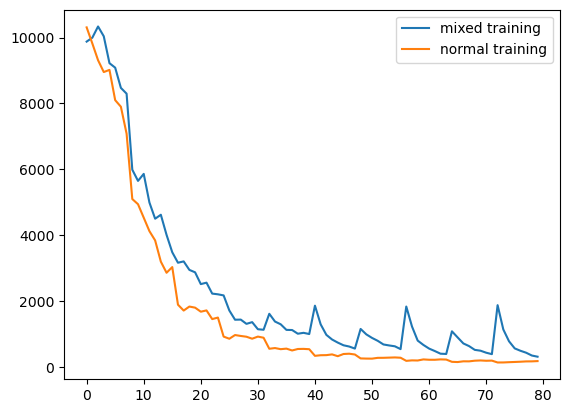

In [19]:
small_net = SmallNet(100,200,100)
big_net = SmallNet(100,399,100)
loss_hist, loss_mixed = mixed_training(data_X, data_y, big_net, small_net, 0.005, 0.005, 5, 1, 32)
plt.plot(torch.arange(len(loss_mixed))*1, loss_mixed, label='mixed training')
model = SmallNet(100,399,100)
loss_hist_normal = train_fullnet(data_X, data_y, model, 0.005, 10, 32)
plt.plot(torch.arange(len(loss_hist_normal)), loss_hist_normal, label='normal training')
plt.legend()
plt.show()

In epoch 0:
loss:7376.036376953125
In epoch 1:
loss:6862.722106933594
In epoch 2:
loss:6545.6474609375
In epoch 3:
loss:6094.323547363281
In epoch 4:
loss:5640.138732910156
In epoch 5:
loss:5317.8841552734375
In epoch 6:
loss:5111.074462890625
In epoch 7:
loss:4942.3623046875
In epoch 8:
loss:4840.750793457031
In epoch 9:
loss:4751.73974609375
In epoch 10:
loss:4683.2294921875
In epoch 11:
loss:4635.7747802734375
In epoch 12:
loss:4609.304443359375
In epoch 13:
loss:4568.417724609375
In epoch 14:
loss:4550.912109375
In epoch 15:
loss:4527.164123535156
In epoch 16:
loss:4510.937255859375
In epoch 17:
loss:4494.1116943359375
In epoch 18:
loss:4488.259460449219
In epoch 19:
loss:4472.301330566406
In epoch 20:
loss:4465.2816162109375
In epoch 21:
loss:4452.4398193359375
In epoch 22:
loss:4439.22412109375
In epoch 23:
loss:4443.623474121094
In epoch 24:
loss:4431.793701171875
In epoch 25:
loss:4423.0489501953125
In epoch 26:
loss:4421.409606933594
In epoch 27:
loss:4416.876403808594
In epoc

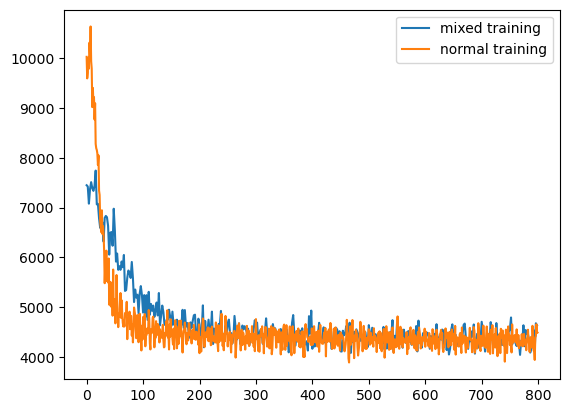

In [20]:
small_net = SmallNet(100,10,100)
big_net = SmallNet(100,19,100)
loss_hist, loss_mixed = mixed_training(data_X, data_y, big_net, small_net, 0.0025, 0.0025, 50, 4, 32)
plt.plot(torch.arange(len(loss_hist))*2, loss_hist, label='mixed training')
model = SmallNet(100,19,100)
loss_hist_normal = train_fullnet(data_X, data_y, model, 0.0025, 100, 32)
plt.plot(torch.arange(len(loss_hist_normal)), loss_hist_normal, label='normal training')
plt.legend()
plt.show()

In [13]:
data_X = torch.randn(128,100) 
print('data_X.shape=', data_X.shape)
solution_true = torch.randn(100,1) # modify output dimension to 1 for overparametrized case
print('solution_true.shape=', solution_true.shape)
noise = 1
data_y = data_X @ solution_true + noise * torch.randn(128,1) # modify output dimension according to X
print('data_y.shape=', data_y.shape)

data_X.shape= torch.Size([128, 100])
solution_true.shape= torch.Size([100, 1])
data_y.shape= torch.Size([128, 1])


In epoch 0:
loss:28.019104480743408
In epoch 1:
loss:7.700604438781738
In epoch 0:
loss:111.72258186340332
In epoch 1:
loss:76.81532955169678
In epoch 2:
loss:27.5908784866333
In epoch 3:
loss:10.657342195510864
In epoch 4:
loss:5.933593392372131
In epoch 5:
loss:3.5554922819137573


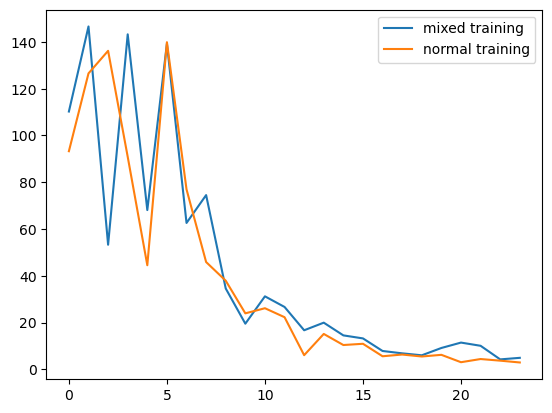

In [14]:
small_net = SmallNet(100,50,1)
big_net = SmallNet(100,99,1)
loss_hist, loss_mixed = mixed_training(data_X, data_y, big_net, small_net, 0.01, 0.01, 2, 2, 32)
plt.plot(torch.arange(len(loss_mixed))*1, loss_mixed, label='mixed training')
model = SmallNet(100,99,1)
loss_hist_normal = train_fullnet(data_X, data_y, model, 0.01, 6, 32)
plt.plot(torch.arange(len(loss_hist_normal)), loss_hist_normal, label='normal training')
plt.legend()
plt.show()

In epoch 0:
loss:32.77633237838745
In epoch 1:
loss:11.292520761489868
In epoch 0:
loss:113.12227058410645
In epoch 1:
loss:78.84017372131348
In epoch 2:
loss:29.01843023300171
In epoch 3:
loss:11.608014583587646
In epoch 4:
loss:6.501746654510498
In epoch 5:
loss:3.918086886405945


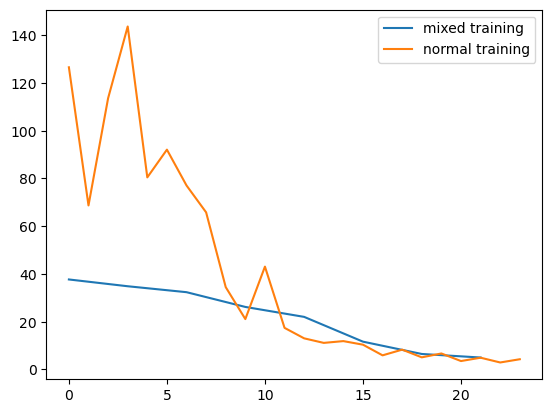

In [15]:
small_net = SmallNet(100,50,1)
big_net = SmallNet(100,99,1)
loss_hist, loss_mixed = mixed_training(data_X, data_y, big_net, small_net, 0.01, 0.01, 2, 2, 32)
plt.plot(torch.arange(len(loss_hist))*3, loss_hist, label='mixed training')
model = SmallNet(100,99,1)
loss_hist_normal = train_fullnet(data_X, data_y, model, 0.01, 6, 32)
plt.plot(torch.arange(len(loss_hist_normal)), loss_hist_normal, label='normal training')
plt.legend()
plt.show()